## Задание 1: Модификация существующих моделей (30 баллов)

### 1.1 Расширение линейной регрессии (15 баллов)
```python
# Модифицируйте существующую линейную регрессию:
# - Добавьте L1 и L2 регуляризацию
# - Добавьте early stopping
```

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from regression_basics.utils import make_regression_data, mse, log_epoch, RegressionDataset

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_value = None
        self.early_stop = False

    def __call__(self, current_value):
        if self.best_value is None:
            self.best_value = current_value
            return False
        
        if self.mode == 'min':
            improved = current_value < (self.best_value - self.min_delta)
        else:  # mode == 'max'
            improved = current_value > (self.best_value + self.min_delta)
        
        if improved:
            self.best_value = current_value
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        return self.early_stop


class LinearRegression(nn.Module):
    def __init__(self, in_features, l1_lambda=0.0, l2_lambda=0.0):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.early_stopping = EarlyStopping()
        
    def init_early_stopping(self, patience=5, min_delta=0.0):
        self.early_stopping = EarlyStopping(patience, min_delta)
        
    def forward(self, x):
        return self.linear(x)
    
    def regularization_loss(self):
        l1_loss = 0.0
        l2_loss = 0.0
        
        for param in self.parameters():
            if self.l1_lambda > 0:
                l1_loss += torch.norm(param, 1)
            if self.l2_lambda > 0:
                l2_loss += torch.norm(param, 2)
                
        return self.l1_lambda * l1_loss + self.l2_lambda * l2_loss
    
    def fit(self, dataloader, criterion, optimizer, epochs=100):
        history = {'loss': []}
        
        for epoch in range(1, epochs + 1):
            self.train()
            total_loss = 0
            
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                y_pred = self(batch_X)
                loss = criterion(y_pred, batch_y) + self.regularization_loss()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(dataloader)
            history['loss'].append(avg_loss)
            
            if self.early_stopping(avg_loss):
                print(f"Early stopping на эпохе {epoch}. Лучший loss: {self.early_stopping.best_value:.4f}")
                break
                
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: loss={avg_loss:.4f}")
        
        return history

if __name__ == '__main__':
    # Генерируем данные
    X, y = make_regression_data(n=200)
    
    # Создаем Dataset и DataLoader
    dataset = RegressionDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    print(f'Размер датасета: {len(dataset)}')
    print(f'Количество батчей: {len(dataloader)}')
    
    # Инициализируем модель и компоненты обучения
    model = LinearRegression(in_features=1, l1_lambda=0.01, l2_lambda=0.01)
    model.init_early_stopping(patience=30, min_delta=0.001)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    # Обучаем модель
    history = model.fit(dataloader, criterion, optimizer, epochs=100)

### 1.2 Расширение логистической регрессии (15 баллов)
```python
# Модифицируйте существующую логистическую регрессию:
# - Добавьте поддержку многоклассовой классификации
# - Реализуйте метрики: precision, recall, F1-score, ROC-AUC
# - Добавьте визуализацию confusion matrix
```

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from regression_basics.utils import make_classification_data, accuracy, log_epoch, ClassificationDataset

Размер датасета: 200
Количество батчей: 7
Epoch 10: loss=0.6551, acc=0.6696, precision=0.7315, recall=0.6791, f1=0.7043, roc_auc=0.7712
Epoch 20: loss=0.5802, acc=0.8616, precision=0.8678, recall=0.8483, f1=0.8579, roc_auc=0.9419
Epoch 30: loss=0.5301, acc=0.9196, precision=0.9161, recall=0.9060, f1=0.9110, roc_auc=0.9776
Epoch 40: loss=0.4816, acc=0.9420, precision=0.9285, recall=0.9222, f1=0.9253, roc_auc=0.9893
Epoch 50: loss=0.4557, acc=0.9420, precision=0.9516, recall=0.9483, f1=0.9500, roc_auc=0.9946
Epoch 60: loss=0.4237, acc=0.9420, precision=0.9662, recall=0.9638, f1=0.9650, roc_auc=0.9970
Epoch 70: loss=0.3963, acc=0.9554, precision=0.9675, recall=0.9631, f1=0.9653, roc_auc=0.9980
Epoch 80: loss=0.3661, acc=0.9821, precision=0.9735, recall=0.9677, f1=0.9706, roc_auc=0.9989
Epoch 90: loss=0.3532, acc=0.9598, precision=0.9820, recall=0.9785, f1=0.9802, roc_auc=0.9993
Epoch 100: loss=0.3374, acc=0.9688, precision=0.9820, recall=0.9785, f1=0.9802, roc_auc=0.9995

Финальные метрик

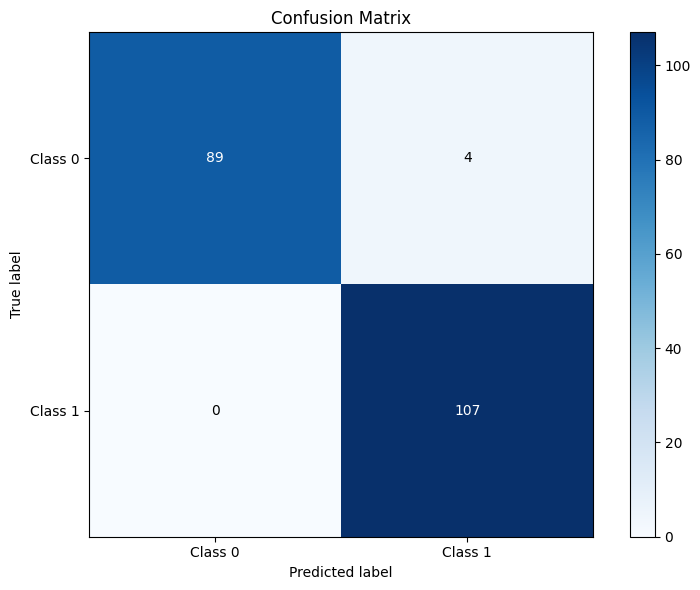

In [22]:
class LogisticRegression(nn.Module):
    def __init__(self, in_features, num_classes=1):
        super().__init__()
        self.num_classes = num_classes
        if num_classes == 1:
            self.linear = nn.Linear(in_features, 1)
        else:
            self.linear = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.linear(x)
    
    def predict_proba(self, x):
        """Возвращает вероятности классов"""
        with torch.no_grad():
            logits = self.forward(x)
            if self.num_classes == 1:
                return torch.sigmoid(logits)
            else:
                return torch.softmax(logits, dim=1)
    
    def predict(self, x):
        """Возвращает предсказанные классы"""
        with torch.no_grad():
            if self.num_classes == 1:
                return (self.predict_proba(x) > 0.5).int()
            else:
                return torch.argmax(self.predict_proba(x), dim=1)
    
    def evaluate(self, X, y):
        self.eval()
        y_true = y.cpu().numpy().flatten()
        y_pred = self.predict(X).cpu().numpy().flatten()
        y_proba = self.predict_proba(X).cpu().numpy()
        
        # Confusion matrix
        cm = self.confusion_matrix(y_true, y_pred)
        
        # Precision, Recall, F1, ROC-AUC
        precision = self.precision_score(y_true, y_pred)
        recall = self.recall_score(y_true, y_pred)
        f1 = self.f1_score(y_true, y_pred)
        roc_auc = self.roc_auc_score(y_true, y_proba)
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': cm
        }
    
    @staticmethod
    def confusion_matrix(y_true, y_pred):
        """Вычисляет матрицу ошибок"""
        classes = np.unique(np.concatenate((y_true, y_pred)))
        n_classes = len(classes)
        cm = np.zeros((n_classes, n_classes), dtype=int)
        
        for i in range(len(y_true)):
            true_idx = int(y_true[i])
            pred_idx = int(y_pred[i])
            cm[true_idx][pred_idx] += 1
            
        return cm
    
    @staticmethod
    def precision_score(y_true, y_pred):
        """Вычисляет precision"""
        cm = LogisticRegression.confusion_matrix(y_true, y_pred)
        n_classes = cm.shape[0]
        precisions = []
        
        for i in range(n_classes):
            tp = cm[i, i]
            fp = np.sum(cm[:, i]) - tp
            
            if tp + fp == 0:
                precisions.append(0.0)
            else:
                precisions.append(tp / (tp + fp))
                
        return np.mean(precisions)
    
    @staticmethod
    def recall_score(y_true, y_pred):
        """Вычисляет recall"""
        cm = LogisticRegression.confusion_matrix(y_true, y_pred)
        n_classes = cm.shape[0]
        recalls = []
        
        for i in range(n_classes):
            tp = cm[i, i]
            fn = np.sum(cm[i, :]) - tp
            
            if tp + fn == 0:
                recalls.append(0.0)
            else:
                recalls.append(tp / (tp + fn))
                
        return np.mean(recalls)
    
    @staticmethod
    def f1_score(y_true, y_pred):
        """Вычисляет F1-score"""
        precision = LogisticRegression.precision_score(y_true, y_pred)
        recall = LogisticRegression.recall_score(y_true, y_pred)
        
        if precision + recall == 0:
            return 0.0
        
        return 2 * (precision * recall) / (precision + recall)
    
    @staticmethod
    def roc_auc_score(y_true, y_proba):
        """Вычисляет ROC-AUC"""
        classes = np.unique(y_true)
        n_classes = len(classes)
        
        # Для бинарной классификации
        if n_classes == 2:
            # Исправление для бинарного случая с одним выходом
            if y_proba.shape[1] == 1:
                return LogisticRegression._binary_roc_auc(y_true, y_proba.ravel())
            else:
                return LogisticRegression._binary_roc_auc(y_true, y_proba[:, 1])
        
        # Для многоклассовой классификации (One-vs-Rest)
        auc_scores = []
        
        for c in classes:
            # Бинаризуем метки для текущего класса
            y_true_binary = (y_true == c).astype(int)
            y_score = y_proba[:, c]
            
            auc = LogisticRegression._binary_roc_auc(y_true_binary, y_score)
            auc_scores.append(auc)
            
        return np.mean(auc_scores)
    
    @staticmethod
    def _binary_roc_auc(y_true, y_score):
        """Вычисляет ROC-AUC для бинарной классификации"""
        # Сортируем по убыванию вероятности
        indices = np.argsort(y_score)[::-1]
        y_true_sorted = y_true[indices]
        
        # Считаем количество положительных и отрицательных примеров
        n_pos = np.sum(y_true)
        n_neg = len(y_true) - n_pos
        
        if n_pos == 0 or n_neg == 0:
            return 0.5
        
        # Вычисляем количество накопленных положительных и отрицательных
        tpr = []  # True Positive Rate
        fpr = []  # False Positive Rate
        tp = 0
        fp = 0
        
        # Порог снижается от самого высокого значения
        prev_score = y_score[indices[0]] + 1  # Гарантируем первый шаг
        for i in range(len(y_true_sorted)):
            current_score = y_score[indices[i]]
            
            # Если оценка изменилась, добавляем текущую точку
            if current_score != prev_score:
                tpr.append(tp / n_pos)
                fpr.append(fp / n_neg)
                prev_score = current_score
            
            if y_true_sorted[i] == 1:
                tp += 1
            else:
                fp += 1
        
        # Добавляем последнюю точку
        tpr.append(tp / n_pos)
        fpr.append(fp / n_neg)
        
        # Вычисляем AUC методом трапеций
        auc = 0.0
        for i in range(1, len(fpr)):
            auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
            
        return auc
    
    @staticmethod
    def plot_confusion_matrix(cm, class_names=None):
        """Визуализирует матрицу ошибок"""
        plt.figure(figsize=(8, 6))
        
        if class_names is None:
            class_names = [str(i) for i in range(len(cm))]
        
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        
        # Добавляем подписи
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         verticalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    # Генерируем данные
    X, y = make_classification_data(n=200)
    
    # Исправление: преобразуем y в одномерный тензор
    y = y.view(-1)
    
    # Создаём датасет и даталоадер
    dataset = ClassificationDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    print(f'Размер датасета: {len(dataset)}')
    print(f'Количество батчей: {len(dataloader)}')
    
    # Создаём модель
    model = LogisticRegression(in_features=2, num_classes=1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    # Обучаем модель
    epochs = 100
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_acc = 0
        num_batches = 0
        
        for i, (batch_X, batch_y) in enumerate(dataloader):
            optimizer.zero_grad()
            logits = model(batch_X)
            
            # Исправление: преобразуем batch_y в нужную форму
            batch_y = batch_y.view(-1, 1).float()
            
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            
            # Вычисляем accuracy
            y_pred = torch.sigmoid(logits)
            acc = accuracy(y_pred, batch_y)
            
            total_loss += loss.item()
            total_acc += acc
            num_batches = i + 1
        
        avg_loss = total_loss / num_batches
        avg_acc = total_acc / num_batches
        
        if epoch % 10 == 0:
            # Вычисляем метрики
            # Исправление: преобразуем y в нужную форму для оценки
            metrics = model.evaluate(X, y.view(-1, 1))
            log_epoch(
                epoch, 
                avg_loss, 
                acc=avg_acc,
                precision=metrics['precision'],
                recall=metrics['recall'],
                f1=metrics['f1'],
                roc_auc=metrics['roc_auc']
            )
    
    # Финальная оценка
    metrics = model.evaluate(X, y.view(-1, 1))
    print("\nФинальные метрики:")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")
    print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    
    # Визуализация confusion matrix
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])
    model.plot_confusion_matrix(
        metrics['confusion_matrix'], 
        class_names=['Class 0', 'Class 1']
    )

Epoch 10: loss=0.7959, acc=0.6937, precision=0.8042, recall=0.5248, f1=0.6352, roc_auc=0.9689
Epoch 20: loss=0.6878, acc=0.7667, precision=0.8603, recall=0.7172, f1=0.7823, roc_auc=0.9858
Epoch 30: loss=0.5983, acc=0.8208, precision=0.8827, recall=0.7672, f1=0.8209, roc_auc=0.9909
Epoch 40: loss=0.5410, acc=0.8427, precision=0.8984, recall=0.8028, f1=0.8479, roc_auc=0.9936
Epoch 50: loss=0.4920, acc=0.8833, precision=0.9101, recall=0.8402, f1=0.8737, roc_auc=0.9949
Epoch 60: loss=0.4581, acc=0.9031, precision=0.9262, recall=0.8775, f1=0.9012, roc_auc=0.9956
Epoch 70: loss=0.4342, acc=0.9000, precision=0.9301, recall=0.8864, f1=0.9077, roc_auc=0.9962
Epoch 80: loss=0.4155, acc=0.9208, precision=0.9461, recall=0.9162, f1=0.9309, roc_auc=0.9966
Epoch 90: loss=0.3804, acc=0.9437, precision=0.9514, recall=0.9251, f1=0.9381, roc_auc=0.9970
Epoch 100: loss=0.3667, acc=0.9500, precision=0.9568, recall=0.9340, f1=0.9453, roc_auc=0.9973

Финальные метрики для 3 классов:
Precision: 0.9568
Recall:

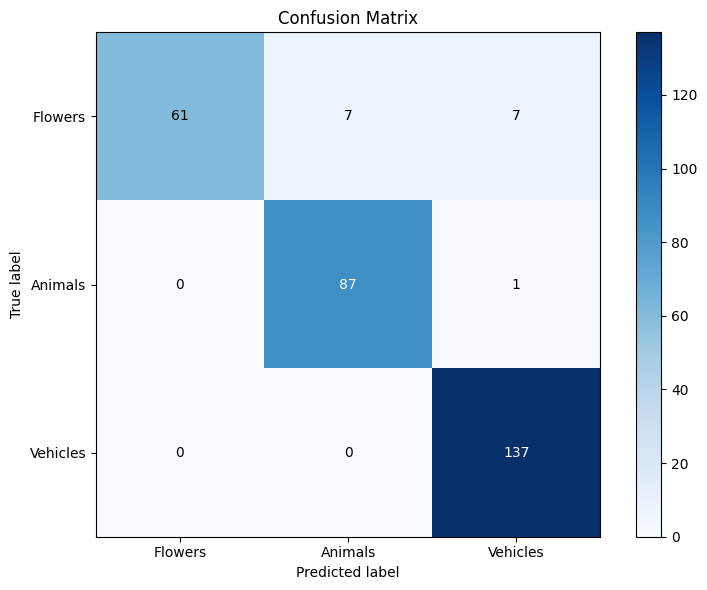

In [23]:
if __name__ == '__main__':
    # Генерируем данные для 3 классов
    n = 300
    X = torch.rand(n, 2)
    
    # Создаем 3 кластера
    centers = torch.tensor([
        [0.2, 0.2],  # Класс 0
        [0.8, 0.2],  # Класс 1
        [0.5, 0.8]   # Класс 2
    ])
    
    y = torch.zeros(n, dtype=torch.long)
    for i in range(n):
        # Определяем ближайший центр
        distances = torch.sum((X[i] - centers) ** 2, dim=1)
        y[i] = torch.argmin(distances)
    
    # Создаём датасет и даталоадер
    dataset = ClassificationDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Создаём модель для 3 классов
    model = LogisticRegression(in_features=2, num_classes=3)
    criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    # Обучаем модель
    epochs = 100
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_acc = 0
        num_batches = 0
        
        for i, (batch_X, batch_y) in enumerate(dataloader):
            optimizer.zero_grad()
            logits = model(batch_X)
            
            # Для CrossEntropyLoss нужно преобразовать y в [batch_size]
            loss = criterion(logits, batch_y.view(-1).long())
            loss.backward()
            optimizer.step()
            
            # Вычисляем accuracy
            y_pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            acc = (y_pred == batch_y.view(-1)).float().mean().item()
            
            total_loss += loss.item()
            total_acc += acc
            num_batches = i + 1
        
        avg_loss = total_loss / num_batches
        avg_acc = total_acc / num_batches
        
        if epoch % 10 == 0:
            # Вычисляем метрики
            metrics = model.evaluate(X, y.unsqueeze(1))
            log_epoch(
                epoch, 
                avg_loss, 
                acc=avg_acc,
                precision=metrics['precision'],
                recall=metrics['recall'],
                f1=metrics['f1'],
                roc_auc=metrics['roc_auc']
            )
    
    # Финальная оценка
    metrics = model.evaluate(X, y.unsqueeze(1))
    print("\nФинальные метрики для 3 классов:")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")
    print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    
    # Визуализация confusion matrix
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])
    model.plot_confusion_matrix(
        metrics['confusion_matrix'], 
        class_names=['Flowers', 'Animals', 'Vehicles']  # Пример осмысленных названий
    )
